In [ ]:
co_occurence_path_2016_t2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T8/edgelist-OktDes2017-10countries.csv', header=None)
occurence_path_2016_t2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T8/node-OktDes2017-10countries.csv', header=None)
occurence_path_2016_t2[[0, 1, 2]]

,0,1,2
0,database,291,True
1,python,3555,True
2,javascript,1142,True
3,r,514,True
4,big-data,1154,True
...,...,...,...
1901,linked-data,2,False
1902,scada,1,False
1903,smpp,1,False
1904,cuda,1,False


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
from tqdm import tqdm
import seaborn as sns
import json

# Data Preparation

In [ ]:
def removeHyperLink(s):
  return s.rsplit('/', 1)[-1]

def removeWhiteSpaces(s):
  return s.strip()

#Similarity Formula Functions

**prepare unique pairs of nodes**

In [ ]:
def getUniquePairOfNodes(df):
  node_pair_list = []
  for index, row in df.iterrows():
    temp_l = [row["skill_a"], row["skill_b"]]
    node_pair_list.append(temp_l)
  new_list = []
  temp_list = node_pair_list.copy()
  for item in temp_list:
    item.sort()
    if item not in new_list:
      new_list.append(item)
  node_pair_list = new_list
  result_df = pd.DataFrame(node_pair_list, columns=['node_a', 'node_b'])
  return result_df

**Get Neigbours of node**

In [ ]:
def getAllUniqueNodes(df):
  skill_a_list = list(df["skill_a"])
  skill_b_list = list(df["skill_b"])
  all_nodes = skill_a_list + skill_b_list
  unique_nodes = list(set(all_nodes))
  return unique_nodes

In [ ]:
def getNeigboursOfNode(df,node):
  neighbours = [node]
  left_n = list(df.query('skill_a == "' + node + '"')["skill_b"])
  right_n = list(df.query('skill_b == "' + node + '"')["skill_a"])
  all_neighbours = left_n + right_n + neighbours
  all_neighbours = list(set(all_neighbours))
  return all_neighbours

**Prepare dataframe with unique nodes and their neighbours**

In [ ]:
def createNeighbourDataSet(df):
  unique_nodes = getAllUniqueNodes(df)
  nodes_with_neighbours = []
  for node in unique_nodes:
    neighbours = getNeigboursOfNode(df,node)
    temp_l = [node, neighbours, len(neighbours)]
    nodes_with_neighbours.append(temp_l)
  neighbour_df = pd.DataFrame(nodes_with_neighbours, columns=['Node', 'Neighbours', 'N_len'])
  return neighbour_df

**Get Neighbour Count**

In [ ]:
def getNeighbourCount(node, df):
  n_count = list(df.query('Node == "' + node + '"')["N_len"])
  if n_count:
    n_count = n_count[0]
  else:
    n_count = 0
  return n_count

**Get Common neighbour nodes**

In [ ]:
def getCommonNeighbourNodes(node1, node2, df):
  n1 = list(df.query('Node == "' + node1 + '"')["Neighbours"])
  if n1:
    n1 = n1[0]
  else:
    n1 = []
  n2 = list(df.query('Node == "' + node2 + '"')["Neighbours"])
  if n2:
    n2 = n2[0]
  else:
    n2 = []
  n1_set = set(n1) 
  n2_set = set(n2) 

  if (n1_set & n2_set):
    return list(n1_set & n2_set)
  else:
    return []  

#calculate Similarity 𝜎(v,w)

E(ij) = [C(ij)]^2 / [C(i)*C(j)]

In [ ]:
def calculateSigmaTwoNodes(df_co_occ, df_occ, df, n1, n2):
  c_i_j1 = df_co_occ.query('skill_a == "' + n1 + '" and skill_b == "' + n2 + '"')[["co_occurence"]]
  c_i_j2 = df_co_occ.query('skill_a == "' + n2 + '" and skill_b == "' + n1 + '"')[["co_occurence"]]
  c_i_j = c_i_j1.append(c_i_j2, ignore_index=False)
  c_i_j = c_i_j.drop_duplicates()
  c_i_j_sum = c_i_j["co_occurence"].sum()

  # # get occurenct of c_i and c_j
  c_i = df_occ.query('skill == "' + n1 + '"')[["occurence"]]
  c_i = c_i.drop_duplicates()
  c_i_sum = c_i["occurence"].sum()
  c_j = df_occ.query('skill == "' + n2 + '"')[["occurence"]]
  c_j = c_j.drop_duplicates()
  c_j_sum = c_j["occurence"].sum()

  # calculate equivalence index
  sigma = (np.square(c_i_j_sum))/ (c_i_sum * c_j_sum)
  
  return sigma

In [ ]:
# calculateSigmaTwoNodes(df_t1_de, df_t1_occ_de, df_t1_de_neighbours, 'javascript', 'selenium')

In [ ]:
# def calculateSigmaTwoNodes(df, n1, n2):
#   common_nodes = len(getCommonNeighbourNodes(n1, n2, df))
#   neighbours_n1_count = getNeighbourCount(n1, df)
#   neighbours_n2_count = getNeighbourCount(n2, df)
#   if common_nodes > 0:
#     sigma = common_nodes/np.sqrt(neighbours_n1_count*neighbours_n2_count)
#   else:
#     sigma = 0
#   return sigma

In [ ]:
def dataPreparation(co_occurence_data, occurence_data, country_code):
  co_occ_colnames=['skill_a', 'skill_b', 'co_occurence', 'A', 'B', 'C', 'D', 'E', 'time', 'country']
  occ_col_names = ['skill', 'occurence', 'A', 'B', 'country','C']
  co_occ_df = pd.read_csv(co_occurence_data, names=co_occ_colnames, header=None)
  occ_df = pd.read_csv(occurence_data, names=occ_col_names, header=None)

  # co_occ_df['skill_a'] = co_occ_df['skill_a'].apply(removeHyperLink).apply(removeWhiteSpaces)
  # co_occ_df['skill_b'] = co_occ_df['skill_b'].apply(removeHyperLink).apply(removeWhiteSpaces)
  # co_occ_df['country'] = co_occ_df['country'].apply(removeWhiteSpaces)

  # occ_df['skill'] = occ_df['skill'].apply(removeHyperLink).apply(removeWhiteSpaces)
  # occ_df['country'] = occ_df['country'].apply(removeWhiteSpaces)
  
  # filter only country rows
  co_occ_df = co_occ_df.query('country == "' + country_code + '"')
  occ_df = occ_df.query('country == "' + country_code + '"')

  # get all unique nodes
  unique_nodes_pairs = getUniquePairOfNodes(co_occ_df)
  
  # get Neigbours
  df_neighbours = createNeighbourDataSet(co_occ_df)

  # Sigma calculation
  node_pair_similarity = []
  for index, row in unique_nodes_pairs.iterrows():
    temp_sigma = calculateSigmaTwoNodes(co_occ_df, occ_df, df_neighbours, row["node_a"], row["node_b"])
    temp_list = [row["node_a"], row["node_b"], temp_sigma]
    node_pair_similarity.append(temp_list)
  node_pair_with_sigma = pd.DataFrame(node_pair_similarity, columns=["node_a", "node_b", "sigma"])
  
  return co_occ_df, occ_df, df_neighbours, unique_nodes_pairs, node_pair_with_sigma

#Similarity calculation with temporal Smoothness for T2 and after


In [ ]:
def applyTemporalSmoothing(node_pair_with_sigma_t2, node_pair_with_sigma_t1, alpha):
  result_list = []
  for index, row in node_pair_with_sigma_t2.iterrows():
    node_a = row["node_a"]
    node_b = row["node_b"]
    sigma_t2 = row["sigma"]
    # get sigma_t1 for node pair, if it exist then good else keep sigma_t1 = 0
    sigma_t1 = list(node_pair_with_sigma_t1.query('node_a=="' + node_a + '" and node_b=="' + node_b + '" or node_a=="' + node_b + '" and node_b=="' + node_a + '"')["sigma"])
    if not sigma_t1:
      sigma_t1_val = 0.0
    else:
      sigma_t1_val = sigma_t1[0]
    sigma_final = alpha*(sigma_t2 - sigma_t1_val) + sigma_t1_val
    result_list.append([node_a, node_b, sigma_final])
  result_df = pd.DataFrame(result_list, columns=['node_a', 'node_b', 'sigma'])
  return result_df

**get Epsilon Neighbourhood of all the nodes**

In [ ]:
def getEpsilonNeighbourhood(df, sigma_df, eps):
  eps_neigbours = []
  for index, row in df.iterrows():
    neighbours = row["Neighbours"]
    eps_neigbours_of_node = []
    for item in neighbours:
      #find similarity distance between node and neighbour node
      if item != row["Node"]:
        similarity = list(sigma_df.query('node_a == "'+ row["Node"] + '" and node_b == "' + item + '"')["sigma"])
        if not similarity:
          similarity = list(sigma_df.query('node_b == "'+ row["Node"] + '" and node_a == "' + item + '"')["sigma"])
        if similarity[0] >= eps:
          eps_neigbours_of_node.append(item)
    eps_neigbours.append([row["Node"], row["Neighbours"], row["N_len"], eps_neigbours_of_node, len(eps_neigbours_of_node)])
  df = pd.DataFrame(eps_neigbours, columns=["Node", "Neighbours", "N_len", "Eps_Neighbour", "Eps_N_len"])
  return df

# DBScan Clustering Process 

In [ ]:
def getCoreNodes(df_eps_neighbour, min_points):
  # finding core points
  core_points = df_eps_neighbour[df_eps_neighbour.Eps_N_len >= min_points]
  core_points = list(core_points["Node"])
  return core_points


**Directly Reachable Nodes**

x is directly reachable from v (core node) if x is in eps-neighbourhood of v

**Reachable Nodes**

Node y is reachable from node x, 

In [ ]:
def directlyReachableFromCoreNodes(df, coreNodes, node):  #input - any node
  result = []
  for index, row in df.iterrows():
    if row["Node"] in coreNodes:
      temp_list = row["Eps_Neighbour"]
      if node in temp_list:
        result.append(row["Node"])
  return result                             #output - core nodes to which input node is directly reachable from

In [ ]:
def reachableFromCoreNode(df, coreNodes, allNodes):  #input - core nodes
  result_list = []
  for node in allNodes:
    for core_node in coreNodes:
      if core_node != node:
        isReachable = isReachableFromCoreNode(df, node, core_node, coreNodes)
        if isReachable == 1: 
          temp_list = [node, core_node, isReachable]
          result_list.append(temp_list)
  result_df = pd.DataFrame(result_list, columns=["Node", "Core_node", "is_Reachable"])
  return result_df

def isReachableFromCoreNode(df, node, core_node, coreNodes):
  active_nodes = [node]
  seen_nodes = []
  while True:
    # print('Active:', active_nodes)
    # print('Seen:', seen_nodes)
    if active_nodes:
      n = active_nodes.pop(0)
      # print('processing:', n)
      seen_nodes.append(n)
      temp_DRN = directlyReachableFromCoreNodes(df, coreNodes, n)
      if core_node in temp_DRN:
        # print("bingo")
        # print(temp_DRN)
        return 1
      for i in temp_DRN:
        if i not in seen_nodes and i not in active_nodes:
          active_nodes.append(i)
    else:
      return 0

**Connected Nodes**

A node **v** is connected to node **w** if there is a node **x** such that both **v** and **w** are reachable from **x**

fyi : node is reachable from a core node

In [ ]:
def connectedNodes(df, all_nodes):
  result_list = []
  for i in all_nodes:
    for j in all_nodes:
      if i != j:
        ic = isConnectedNodes(df, i, j)
        if ic == 1:
          temp_list = [i, j, ic]
          result_list.append(temp_list)
  result_df = pd.DataFrame(result_list, columns=["A", "B", "is_connected"])
  return result_df

def isConnectedNodes(df, a, b):
  # get nodes from which a is reachable
  a_reachable = list(df.query('Node == "'+ a + '" and is_Reachable == "1"', inplace = False)["Core_node"])
  # get nodes from which b is reachable
  b_reachable = list(df.query('Node == "'+ b + '" and is_Reachable == "1"', inplace = False)["Core_node"])
  # get common
  a_set = set(a_reachable)
  b_set = set(b_reachable)

  if (a_set & b_set):
    return 1 
  else:
    return 0

In [ ]:
def isConnected(df, n1, n2):
  x = len(list(df.query('A == "'+ n1 + '" and B == "' + n2 + '"', inplace = False)["is_connected"]))
  y = len(list(df.query('A == "'+ n2 + '" and B == "' + n1 + '"', inplace = False)["is_connected"]))
  if x >= 1 or y >= 1:
    return True
  else:
    return False

#Clustering-Function

Rule 1: if **v** is in **S** and **w** is reachable from v, then w is also in **S**

Rule 2: for all v, w belongs to **S**, v is connected to w

In [ ]:
def ClusteringProcess(eps, min_points, df_neighbours, node_pair_with_sigma):
  # get Epsilon Neighbours
  df_eps_neighbours = getEpsilonNeighbourhood(df_neighbours, node_pair_with_sigma, eps)
  # all node list
  all_nodes = list(df_eps_neighbours["Node"])

  # get core nodes
  core_nodes = getCoreNodes(df_eps_neighbours, min_points)
  
  # get Non-core nodes
  non_core_nodes = []
  for i in all_nodes:
    if i not in core_nodes:
      non_core_nodes.append(i)

  # get Reachable nodes DF
  reachableNodesDF = reachableFromCoreNode(df_eps_neighbours, core_nodes, all_nodes)
  # get connected nodes DF
  connected_node_df = connectedNodes(reachableNodesDF, all_nodes)

  # # Making copies
  temp_core_nodes = core_nodes.copy()
  temp_non_core_nodes = non_core_nodes.copy()
  temp_all_nodes = all_nodes.copy()

  # # Clustering Process
  clusters = []
  while len(temp_core_nodes) > 0:
    temp_cluster = []
    core = temp_core_nodes.pop(0)
    
    # Intialize core with core element
    temp_cluster.append(core)
    # Add elements which are reachable from core element
    unprocessed_nodes = []
    rchbl = list(reachableNodesDF.query('Core_node == "'+ core + '"', inplace = False)["Node"])
    
    # processed_nodes.append(core)
    unprocessed_nodes = unprocessed_nodes + rchbl
    temp_cluster = temp_cluster + rchbl
    #No need to check connectivity for now; as there is only one core node and nodes reachable from it
    while len(unprocessed_nodes) > 0:
      k = unprocessed_nodes.pop(0)
      if k in core_nodes:
        # find it's reachable nodes
        temp_rchbl = list(reachableNodesDF.query('Core_node == "'+ k + '"', inplace = False)["Node"])
        # check the connectivity of these temp_rchbl nodes from all the nodes present in temp_cluster
        for nod in temp_rchbl:
          not_connected = 0
          for cn in temp_cluster:
            isConct = isConnected(connected_node_df, nod, cn)
            if isConct == False:
              not_connected = 1
          if not_connected == 0:
            temp_cluster.append(nod)
            unprocessed_nodes.append(nod) # adding as we need to process it's reachable nodes too

    # now let's remove the nodes of temp_cluster from core_node and all_node list
    for nod in temp_cluster:
      if nod in temp_core_nodes:
        temp_core_nodes.remove(nod)
      if nod in temp_all_nodes:
        temp_all_nodes.remove(nod)
    # cluster is ready
    clusters.append(temp_cluster)
  noise_nodes = temp_all_nodes.copy()
  return clusters, noise_nodes

#Modularity (Q_mid) calculation for EPs optimization

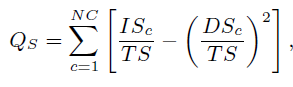

where NC is the number of clusters, TS the total simi-
larity between all pairs of nodes in the graph, ISc the total
similarity of a pair of nodes within a cluster c, DSc the total
similarity between a node in the cluster c and any node in
the graph.

In [ ]:
def getModularity(df, clusters):
  modularity = 0
  TS = df.sum(axis = 0, skipna = True).sigma
  for cluster in clusters:
    internal_cluster_edges = getClusterInternalEdges(df, cluster)
    ISc = internal_cluster_edges.sum(axis = 0, skipna = True).sigma

    all_cluster_edges = getClusterAllEdges(df, cluster)
    DSc = all_cluster_edges.sum(axis = 0, skipna = True).sigma

    sum_value = (ISc/TS) - np.square(DSc/TS)
    
    modularity += sum_value

  return modularity

In [ ]:
def getClusterInternalEdges(df, cluster):
  return df[df['node_a'].isin(cluster) & df['node_b'].isin(cluster)]

def getClusterAllEdges(df, cluster):
  tmp_all_1 = df[df['node_a'].isin(cluster)] 
  tmp_all_2 = df[df['node_b'].isin(cluster)]
  tmp_all = pd.concat([tmp_all_1, tmp_all_2])
  tmp_all.reset_index(drop=True, inplace=True)
  tmp_all = tmp_all.drop_duplicates()
  return tmp_all

def getClusterExternalEdges(df, cluster):
  internal_edges = getClusterInternalEdges(df, cluster)
  all_edges = getClusterAllEdges(df, cluster)
  dfs_dictionary = {'DF1':internal_edges,'DF2':all_edges}
  external_edges = pd.concat(dfs_dictionary)
  external_edges = external_edges.drop_duplicates(keep=False)
  return external_edges

# Optimization of Eps

In [ ]:
def findBestEps(mean_eps, df_neighbours, node_pair_with_sigma):
  min_points_list = [2]
  step_size = 0.02
  # start_eps = mean_eps - .10
  # end_eps = mean_eps + 0.10
  start_eps = 0.30
  end_eps = 0.34
  if start_eps < 0.05:
    diff = 0.05 - start_eps
    start_eps = .02
    end_eps = end_eps + diff
  start_eps = float("{:.2f}".format(start_eps))
  end_eps = float("{:.2f}".format(end_eps))
  modu_list = []
  all_eps_list = []
  clusters_res_list = []
  noise_res_list = []
  for eps in tqdm(np.arange(start_eps, end_eps, step_size)):
    for min_point in min_points_list:
      print("processing - ", eps)
      print("min_point - ", min_point)
      temp_clusters, temp_noise_nodes = ClusteringProcess(eps, min_point, df_neighbours, node_pair_with_sigma)
      temp_Q_mid = getModularity(node_pair_with_sigma, temp_clusters)
      all_eps_list.append(eps)
      modu_list.append(temp_Q_mid)
      clusters_res_list.append(temp_clusters)
      noise_res_list.append(temp_noise_nodes)

      print("Modularity=",temp_Q_mid)
      print("======================================")

  max_index = modu_list.index(max(modu_list))

  print(modu_list)
  print("Modularity=",modu_list[max_index])
  print("EPs=", all_eps_list[max_index])
  print(clusters_res_list[max_index])
  print("======================================")

  return all_eps_list[max_index], clusters_res_list[max_index], noise_res_list[max_index], modu_list[max_index], all_eps_list, modu_list

**Prepare cluster for 2 consecutive timeframe**

In [ ]:
# min_points = 2
# alpha = 1
# Network_nodes_df =  pd.DataFrame(columns=['node_id', 'Node'])

# get correct eps for different time frames

In [ ]:
# co_occurence_path_2016_t1 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T7/edgelist-JulSep2017.csv'
# occurence_path_2016_t1 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T7/node-JulSep2017.csv'

# co_occ_df_2016_t1, occ_df_2016_t1, df_neighbours_2016_t1, unique_nodes_pairs_2016_t1, node_pair_with_sigma_2016_t1 = dataPreparation(co_occurence_path_2016_t1, occurence_path_2016_t1, 'de')

# mean_sigma_2016_t1 = node_pair_with_sigma_2016_t1["sigma"].mean()
# print("mean is ",mean_sigma_2016_t1)
# mean_sigma_2016_t1 = float("{:.2f}".format(mean_sigma_2016_t1))
# optimal_eps_2016_t1, clusters_2016_t1, noise_nodes_2016_t1, modularity_2016_t1 = findBestEps(mean_sigma_2016_t1, min_points, df_neighbours_2016_t1, node_pair_with_sigma_2016_t1)
# print("Best eps JulSep2017 = ", optimal_eps_2016_t1)

######################

# co_occurence_path_2016_t2 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T8/edgelist-OktDes2017-10countries.csv'
# occurence_path_2016_t2 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T8/node-OktDes2017-10countries.csv'

# co_occ_df_2016_t2, occ_df_2016_t2, df_neighbours_2016_t2, unique_nodes_pairs_2016_t2, node_pair_with_sigma_2016_t2 = dataPreparation(co_occurence_path_2016_t2, occurence_path_2016_t2, 'de')
# mean_sigma_2016_t2 = node_pair_with_sigma_2016_t2["sigma"].mean()
# print("Mean is ", mean_sigma_2016_t2)
# mean_sigma_2016_t2 = float("{:.2f}".format(mean_sigma_2016_t2))
# optimal_eps_2016_t2, clusters_2016_t2, noise_nodes_2016_t2, modularity_2016_t2 = findBestEps(mean_sigma_2016_t2, min_points, df_neighbours_2016_t2, node_pair_with_sigma_2016_t2)
# print("Best eps octdec 2017 = ", optimal_eps_2016_t2)

# node_pair_with_sigma_2016_t2_a = applyTemporalSmoothing(node_pair_with_sigma_2016_t2, node_pair_with_sigma_2016_t1, 0.2)
# mean_sigma_2016_t2 = node_pair_with_sigma_2016_t2_a["sigma"].mean()
# mean_sigma_2016_t2 = float("{:.2f}".format(mean_sigma_2016_t2))
# optimal_eps_2016_t2, clusters_2016_t2, noise_nodes_2016_t2, modularity_2016_t2 = findBestEps(mean_sigma_2016_t2, min_points, df_neighbours_2016_t2, node_pair_with_sigma_2016_t2_a)
# print("AprJun2016_0.2 = ", optimal_eps_2016_t2)

# node_pair_with_sigma_2016_t2_b = applyTemporalSmoothing(node_pair_with_sigma_2016_t2, node_pair_with_sigma_2016_t1, 0.8)
# mean_sigma_2016_t2 = node_pair_with_sigma_2016_t2_b["sigma"].mean()
# mean_sigma_2016_t2 = float("{:.2f}".format(mean_sigma_2016_t2))
# optimal_eps_2016_t2, clusters_2016_t2, noise_nodes_2016_t2, modularity_2016_t2 = findBestEps(mean_sigma_2016_t2, min_points, df_neighbours_2016_t2, node_pair_with_sigma_2016_t2_b)
# print("AprJun2016_0.8 = ", optimal_eps_2016_t2)

############################

# co_occurence_path_2016_t3 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T3/edgelist-JulSep2016.csv'
# occurence_path_2016_t3 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T3/node-JulSep2016.csv'

# co_occ_df_2016_t3, occ_df_2016_t3, df_neighbours_2016_t3, unique_nodes_pairs_2016_t3, node_pair_with_sigma_2016_t3 = dataPreparation(co_occurence_path_2016_t3, occurence_path_2016_t3, 'de')

# mean_sigma_2016_t3 = node_pair_with_sigma_2016_t3["sigma"].mean()
# mean_sigma_2016_t3 = float("{:.2f}".format(mean_sigma_2016_t3))
# optimal_eps_2016_t3, clusters_2016_t3, noise_nodes_2016_t3, modularity_2016_t3 = findBestEps(mean_sigma_2016_t3, min_points, df_neighbours_2016_t3, node_pair_with_sigma_2016_t3)
# print("Best eps JULSEP2016 = ",optimal_eps_2016_t3)

###########################

# co_occurence_path_2016_t4 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T4/edgelist-OktDes2016.csv'
# occurence_path_2016_t4 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T4/node-OktDes2016.csv'

# co_occ_df_2016_t4, occ_df_2016_t4, df_neighbours_2016_t4, unique_nodes_pairs_2016_t4, node_pair_with_sigma_2016_t4 = dataPreparation(co_occurence_path_2016_t4, occurence_path_2016_t4, 'de')

# mean_sigma_2016_t4 = node_pair_with_sigma_2016_t4["sigma"].mean()
# mean_sigma_2016_t4 = float("{:.2f}".format(mean_sigma_2016_t4))
# optimal_eps_2016_t4, clusters_2016_t4, noise_nodes_2016_t4, modularity_2016_t4 = findBestEps(mean_sigma_2016_t4, min_points, df_neighbours_2016_t4, node_pair_with_sigma_2016_t4)
# print("Best eps OktDes2016 = ",optimal_eps_2016_t4)

In [ ]:
# DE --- Data
# JanMar2016 - (.09)
# AprJun2016 - (.05)
# JulSep2016 - (0.03)
# OctDec2016 - 0.03)

# JanMar2017 = .18
# AprJun2017 = .13
# JulSep2017 =  0.08
# octdec2017 = 0.04

# AprJun2017 : 
# with alpha = 0.2: 0.06
# with alpha = 0.8: 0.10
# with alpha = 0.0: 0.02

In [ ]:
# co_occurence_path_t1 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T5/edgelist-JanMar2017.csv'
# occurence_path_t1 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T5/node-JanMar2017.csv'

# co_occ_df_t1, occ_df_t1, df_neighbours_t1, unique_nodes_pairs_t1, node_pair_with_sigma_t1 = dataPreparation(co_occurence_path_t1, occurence_path_t1, 'de')
# mean_sigma_t1 = node_pair_with_sigma_t1["sigma"].mean()
# mean_sigma_t1 = float("{:.2f}".format(mean_sigma_t1))

# optimal_eps_t1, clusters_t1, noise_nodes_t1, modularity_t1 = findBestEps(mean_sigma_t1, min_points, df_neighbours_t1, node_pair_with_sigma_t1)

# clusters_t1, noise_nodes_t1 = ClusteringProcess(.18, min_points, df_neighbours_t1, node_pair_with_sigma_t1)
# Q_mid_t1 = getModularity(node_pair_with_sigma_t1, clusters_t1)

In [ ]:
mod_list = [0.4814832542137488, 0.47973244596406817, 0.47973244596406817, 0.47268146475578354, 0.47268146475578354, 0.49954880786787903, 0.4673588006442232, 0.4673588006442232, 0.4673588006442232, 0.39568383618092207, 0.39568383618092207, 0.395683836180922, 0.395683836180922, 0.2826571617002696, 0.2355916219289209, 0.2355916219289209, 0.2355916219289209, 0.2355916219289209, 0.2355916219289209, 0.2355916219289209]
eps_list = [0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4, 0.42, 0.44, 0.46]

# apr-jun list
# mod_list = [-0.0024937824763165972, 0.005167372691938121, 0.022088611663185764, 0.18717919525545088, 0.18582416325944542, 0.48861735402314765, 0.4735277139390298, 0.39867596230098196, 0.39103693484309754, 0.3739253581169257, 0.3646501653694078, 0.35415805689145025]
# eps_list = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24]

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,8))
sns.set_style('whitegrid')
sns.lineplot(eps_list, mod_list, color='orange', linewidth=2.5)
plt.xlabel('Eps')
plt.ylabel('Modularity')


**Sigma Distribution analysis**

In [ ]:
# all_sigma = list(node_pair_with_sigma_t1["sigma"])
# all_sigma = np.log(all_sigma)
# plt.hist(all_sigma, color = 'blue', edgecolor = 'black', bins = 10)
# node_pair_with_sigma_t1["sigma"] = np.log(node_pair_with_sigma_t1["sigma"])
# node_pair_with_sigma_t1["sigma"].describe()
# lower = node_pair_with_sigma_t1["sigma"].quantile(.25)
# upper = node_pair_with_sigma_t1["sigma"].quantile(.75)
# (upper-lower)/10

In [ ]:
co_occurence_path_t1 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T5/edgelist-JanMar2017.csv'
occurence_path_t1 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T5/node-JanMar2017.csv'

co_occ_df_t1, occ_df_t1, df_neighbours_t1, unique_nodes_pairs_t1, node_pair_with_sigma_t1 = dataPreparation(co_occurence_path_t1, occurence_path_t1, 'de')
node_pair_with_sigma_t1.head(30)
# # mean_sigma_t1 = node_pair_with_sigma_t1["sigma"].mean()
# # mean_sigma_t1 = float("{:.2f}".format(mean_sigma_t1))
# # optimal_eps_t1, clusters_t1, noise_nodes_t1, modularity_t1 = findBestEps(mean_sigma_t1, min_points, df_neighbours_t1, node_pair_with_sigma_t1)

# clusters_t1, noise_nodes_t1 = ClusteringProcess(.18, min_points, df_neighbours_t1, node_pair_with_sigma_t1)
# Q_mid_t1 = getModularity(node_pair_with_sigma_t1, clusters_t1)


,node_a,node_b,sigma
0,javascript,selenium,0.500000
1,business-intelligence,statistics,0.000665
2,business-intelligence,security,0.000818
3,data-analysis,statistics,0.017857
4,design,user-experience,0.052632
5,big-data,data-science,0.050277
6,devops,security,0.111888
7,big-data,devops,0.077700
8,compiler,data-science,0.058824
9,big-data,business-intelligence,0.596563


In [ ]:
# co_occurence_path_t2 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T6/edgelist-AprJun2017.csv'
# occurence_path_t2 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T6/node-AprJun2017.csv'


# co_occ_df_t2, occ_df_t2, df_neighbours_t2, unique_nodes_pairs_t2, node_pair_with_sigma_t2 = dataPreparation(co_occurence_path_t2, occurence_path_t2, 'de')
# node_pair_with_sigma_t2 = applyTemporalSmoothing(node_pair_with_sigma_t2, node_pair_with_sigma_t1, alpha)

# # mean_sigma_t2 = node_pair_with_sigma_t2["sigma"].mean()
# # mean_sigma_t2 = float("{:.2f}".format(mean_sigma_t2))
# # optimal_eps_t2, clusters_t2, noise_nodes_t2, modularity_t2 = findBestEps(mean_sigma_t2, min_points, df_neighbours_t2, node_pair_with_sigma_t2)

# # .12 or .13
# clusters_t2, noise_nodes_t2 = ClusteringProcess(.12, min_points, df_neighbours_t2, node_pair_with_sigma_t2)
# Q_mid_t2 = getModularity(node_pair_with_sigma_t2, clusters_t2)


In [ ]:
# len(clusters_t2)

In [ ]:
# co_occurence_path_t3 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T7/edgelist-JulSep2017.csv'
# occurence_path_t3 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T7/node-JulSep2017.csv'

# co_occ_df_t3, occ_df_t3, df_neighbours_t3, unique_nodes_pairs_t3, node_pair_with_sigma_t3 = dataPreparation(co_occurence_path_t3, occurence_path_t3, 'de')
# node_pair_with_sigma_t3 = applyTemporalSmoothing(node_pair_with_sigma_t3, node_pair_with_sigma_t3, alpha)

# mean_sigma_t3 = node_pair_with_sigma_t3["sigma"].mean()
# mean_sigma_t3 = float("{:.2f}".format(mean_sigma_t3))
# optimal_eps_t3, clusters_t3, noise_nodes_t3, modularity_t3 = findBestEps(mean_sigma_t3, min_points, df_neighbours_t3, node_pair_with_sigma_t3)

# # .11
# # clusters_t3, noise_nodes_t3 = ClusteringProcess(.11, min_points, df_neighbours_t3, node_pair_with_sigma_t3)
# # Q_mid_t3 = getModularity(node_pair_with_sigma_t3, clusters_t3)

In [ ]:
# co_occurence_path_t4 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T8/edgelist-OktDes2017-10countries.csv'
# occurence_path_t4 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T8/node-OktDes2017-10countries.csv'

# co_occ_df_t4, occ_df_t4, df_neighbours_t4, unique_nodes_pairs_t4, node_pair_with_sigma_t4 = dataPreparation(co_occurence_path_t4, occurence_path_t4, 'de')
# node_pair_with_sigma_t4 = applyTemporalSmoothing(node_pair_with_sigma_t4, node_pair_with_sigma_t4, alpha)

# # mean_sigma_t4 = node_pair_with_sigma_t4["sigma"].mean()
# # mean_sigma_t4 = float("{:.2f}".format(mean_sigma_t4))
# # print("Mean Sigma ", mean_sigma_t4)
# # optimal_eps_t4, clusters_t4, noise_nodes_t4, modularity_t4 = findBestEps(mean_sigma_t4, min_points, df_neighbours_t4, node_pair_with_sigma_t4)

# # .11
# clusters_t4, noise_nodes_t4 = ClusteringProcess(.04, min_points, df_neighbours_t4, node_pair_with_sigma_t4)
# Q_mid_t4 = getModularity(node_pair_with_sigma_t4, clusters_t4)

In [ ]:
# print("Modularity - ", Q_mid_t4)
# clusters_t4

#Result File and Json file for Graph drawing

In [ ]:
def getLabelNode(edge_internal, edge_external, node_internal, node_external):
  all_nodes = node_internal.split('#') + node_external.split('#')
  all_nodes = [node for node in all_nodes if node]
  edge_internal_list = edge_internal.split('"')
  edge_external_list = edge_external.split('"')

  # calculate n_cl_in and n_cl_ex
  n_cl_in = 0
  n_cl_ex = 0
  for item in edge_internal_list:
    if item:
      n_cl_in = n_cl_in + float(item.split('#')[2])
  for item in edge_external_list:
    if item:
      n_cl_ex = n_cl_ex + float(item.split('#')[2])
  # calculate W_cl for all nodes
  w_cl_list = []
  for node in all_nodes:
    k_cl = 0
    for item in edge_internal_list:
      temp_list = item.split('#')
      if node in temp_list:
        k_cl = k_cl + float(temp_list[2])
    for item in edge_external_list:
      temp_list = item.split('#')
      if node in temp_list:
        k_cl = k_cl + float(temp_list[2])
    w_cl = k_cl / (n_cl_in + n_cl_ex)
    w_cl_list.append([node, w_cl])
    
  w_cl_df = pd.DataFrame(w_cl_list, columns=['node', 'w_cl'])
  label_node = list(w_cl_df[w_cl_df.w_cl == w_cl_df.w_cl.max()].iloc[0])
  return label_node[0]

In [ ]:
def createGraph(clusters, node_pair_with_sigma, time_label, country):
  graph = []
  for cluster in clusters:
    edge_internal = ""
    edge_external = ""
    node_external = ""
    node_internal = ""
    density_sum = 0
    internal_link_count = 0
    centrality_sum = 0

    node_external_list = []
    for index, row in node_pair_with_sigma.iterrows():
      if row["node_a"] in cluster and row["node_b"] in cluster:
        edge_internal = edge_internal + row["node_a"] + '#' + row["node_b"] + '#' + str(row["sigma"]) + '"'
        density_sum = density_sum + float("{:.2f}".format(row["sigma"]))
        internal_link_count = internal_link_count + 1
      elif row["node_a"] in cluster or row["node_b"] in cluster:
        edge_external = edge_external + row["node_a"] + '#' + row["node_b"] + '#' + str(row["sigma"]) + '"'
        centrality_sum = centrality_sum + float("{:.2f}".format(np.square(row["sigma"])))
        if row["node_a"] not in cluster:
          node_external_list.append(row["node_a"])
        elif row["node_b"] not in cluster:
          node_external_list.append(row["node_b"])
    node_external_list = list(set(node_external_list))
    for item in node_external_list:
      node_external = node_external + item + "#"
    for item in cluster:
      node_internal = node_internal + item + "#"
    # calculation of Density and Centrailty
    density = density_sum / internal_link_count
    centrality = np.sqrt(centrality_sum)
    label_node = getLabelNode(edge_internal, edge_external, node_internal, node_external)

    graph.append([label_node, density, centrality, time_label, country, node_internal, edge_internal, edge_external, node_external])
    
  graph_df = pd.DataFrame(graph, columns=['Label', 'Density', 'Centrality', 'Time_Label', 'Country', 'Node_Internal', 'Edge_Internal', 'Edge_External', 'Node_External'])
  
  # add Quadrant to it
  Centrailty_median = graph_df["Centrality"].median()
  density_median = graph_df["Density"].median()
  
  final_graph_list = []

  for index, row in graph_df.iterrows():
    if row["Density"] >= density_median and row["Centrality"] >= Centrailty_median:
      quadrant = 1
    elif row["Density"] <= density_median and row["Centrality"] >= Centrailty_median:
      quadrant = 2
    elif row["Density"] >= density_median and row["Centrality"] <= Centrailty_median:
      quadrant = 3
    elif row["Density"] <= density_median and row["Centrality"] <= Centrailty_median:
      quadrant = 4
    else:
      quadrant = 1
    
    final_graph_list.append([row["Label"], row["Density"], row["Centrality"], quadrant, row["Time_Label"], row["Country"], row["Node_Internal"], row["Edge_Internal"], row["Edge_External"], row["Node_External"]])
  final_graph_df = pd.DataFrame(final_graph_list, columns=['Label', 'Density', 'Centrality', 'Quadrant', 'Time_Label', 'Country', 'Node_Internal', 'Edge_Internal', 'Edge_External', 'Node_External'])
  return final_graph_df

In [ ]:
# graph_t1 = createGraph(clusters_t1, node_pair_with_sigma_t1, "JanMar2017" ,"de")
# graph_t1.to_csv("/content/drive/My Drive/Colab Notebooks/Particle Density Algo/results/JanMar2017.csv")
# graph_t1.head(10)

# graph_t2 = createGraph(clusters_t2, node_pair_with_sigma_t2, "AprJun2017" ,"de")
# graph_t2.to_csv("/content/drive/My Drive/Colab Notebooks/Particle Density Algo/results/AprJun2017.csv")
# graph_t2.head(10)

# graph_t3 = createGraph(clusters_t3, node_pair_with_sigma_t3, "JulSep2017" ,"de")
# graph_t3.to_csv("/content/drive/My Drive/Colab Notebooks/Particle Density Algo/results/JulSep2017.csv")
# graph_t3.head(10)

# graph_t4 = createGraph(clusters_t4, node_pair_with_sigma_t4, "OctDec2017" ,"de")
# graph_t4.to_csv("/content/drive/My Drive/Colab Notebooks/Particle Density Algo/results/OctDec2017.csv")
# graph_t4.head(10)

In [ ]:
countries = ['gb', 'nl', 'fr', 'de']
time_frames_files = [
                      ['/T1/edgelist-JanMar2016.csv', '/T1/node-JanMar2016.csv', 'JanMar2016'],
                      ['/T2/edgelist-AprJun2016.csv', '/T2/node-AprJun2016.csv', 'AprJun2016'],
                      ['/T3/edgelist-JulSep2016.csv', '/T3/node-JulSep2016.csv', 'JulSep2016'],
                      ['/T4/edgelist-OktDes2016.csv', '/T4/node-OktDes2016.csv', 'OctDec2016'],
                      ['/T5/edgelist-JanMar2017.csv', '/T5/node-JanMar2017.csv', 'JanMar2017'],
                      ['/T6/edgelist-AprJun2017.csv', '/T6/node-AprJun2017.csv', 'AprJun2017'],
                      ['/T7/edgelist-JulSep2017.csv', '/T7/node-JulSep2017.csv', 'JulSep2017'],
                      ['/T8/edgelist-OktDes2017-10countries.csv', '/T8/node-OktDes2017-10countries.csv', 'OctDec2017']
                    ]

In [ ]:
source_path = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data' 
result_path = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/results/'
for country in countries:
  for tf in time_frames_files:
    print(tf[2] + "_" + country)
    co_occurence_path = source_path + tf[0]
    occurence_path = source_path + tf[1]
    
    time_frame = tf[2]
    result_file_path = result_path + time_frame + "_" + country + ".csv"
    print(result_file_path)

    co_occ_df, occ_df, df_neighbours, unique_nodes_pairs, node_pair_with_sigma = dataPreparation(co_occurence_path, occurence_path, country)

    mean_sigma = node_pair_with_sigma["sigma"].mean()
    mean_sigma = float("{:.2f}".format(mean_sigma))
    
    optimal_eps, clusters, noise_nodes, best_modularity, eps_series, mod_series = findBestEps(mean_sigma, df_neighbours, node_pair_with_sigma)

    graph = createGraph(clusters, node_pair_with_sigma, time_frame , country)
    print("eps ", eps_series)
    print("mod ", mod_series)
    print("=====================")
    graph.to_csv(result_file_path, index=False)

In [ ]:
best_modularity

In [ ]:
co_occurence_path_t1 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T8/edgelist-OktDes2017-10countries.csv'
occurence_path_t1 = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/raw_data/Data/T8/node-OktDes2017-10countries.csv'

co_occ_df_t1, occ_df_t1, df_neighbours_t1, unique_nodes_pairs_t1, node_pair_with_sigma_t1 = dataPreparation(co_occurence_path_t1, occurence_path_t1, 'de')

mean_sigma = node_pair_with_sigma_t1["sigma"].mean()
mean_sigma = float("{:.2f}".format(mean_sigma))
print("Mean Sigma ", mean_sigma)
optimal_eps_t4, clusters_t4, noise_nodes_t4, modularity_t4 = findBestEps(mean_sigma, min_points, df_neighbours_t1, node_pair_with_sigma_t1)


# clusters_t1, noise_nodes_t1 = ClusteringProcess(0.04, min_points, df_neighbours_t1, node_pair_with_sigma_t1)
# Q_mid_t1 = getModularity(node_pair_with_sigma_t1, clusters_t1)

# graph_t1 = createGraph(clusters_t1, node_pair_with_sigma_t1, "OktDes2016" ,"de")
# graph_t1.to_csv("/content/drive/My Drive/Colab Notebooks/Particle Density Algo/results/OktDes2016.csv", index=False)

In [ ]:
modularity_t4

In [ ]:
# devops#microservices - 2 co-occ
occ_df_t1.query("skill == 'microservices'")


In [ ]:
graph_t1 = createGraph(clusters_t1, node_pair_with_sigma_t1, "OktDes2016" ,"de")
graph_t1

# Prepare Json from Graph CSV

In [ ]:
# Prepare Json file
def prepareGraphJson(graph_df, filename):
  filename = '/content/drive/My Drive/Colab Notebooks/Particle Density Algo/results/json/'+ filename + '.json'
  # create a json with nodes and edges tags
  with open(filename, 'w') as fp: 
      fp.write('{"nodes":[], "edges":[]}')
  # Append json tags
  with open(filename) as json_file: 
    data = json.load(json_file) 
      
    node_obj = data['nodes'] 
    edge_obj = data['edges']

    cluster_index = 1
    all_cluster_node_list = []
    all_external_node_list = []
    for index, row in graph_df.iterrows():
      # Writing Nodes to file
      cluster_nodes = row["Node_Internal"].split('#')
      for n in cluster_nodes:
        if n:
          node = {
              "id": n,
              "group": cluster_index
          }
          node_obj.append(node)
          all_cluster_node_list.append(n)
      cluster_index = cluster_index + 1

      # Process Edge Internal
      internal_edges = row["Edge_Internal"].split('"')
      for e in internal_edges:
        if e:
          e_arr = e.split('#')
          edge = {
              "from": e_arr[0],
              "to": e_arr[1]
          }
          edge_obj.append(edge)
      # Process Edge Extrnal
      external_edges = row["Edge_External"].split('"')
      for e in external_edges:
        if e:
          e_arr = e.split('#')
          edge = {
              "from": e_arr[0],
              "to": e_arr[1]
          }
          edge_obj.append(edge)
          all_external_node_list.append(e_arr[0])
          all_external_node_list.append(e_arr[1])

    all_external_node_list = list(set(all_external_node_list))
    for n in all_external_node_list:
      if n not in all_cluster_node_list:
        node = {
            "id": n,
            "group": 0
        }
        node_obj.append(node)

  # writing data to json
  with open(filename,'w') as f: 
    json.dump(data, f, indent=4)

In [ ]:
jan_mar_2017_graph = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Particle Density Algo/results/JanMar2017.csv")
prepareGraphJson(jan_mar_2017_graph, 'jan_mar2017')